# Свёрточные сети (6 баллов)

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

## Данные

CIFAR10
* 60k rgb изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучаюую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [0]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

Using TensorFlow backend.


(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

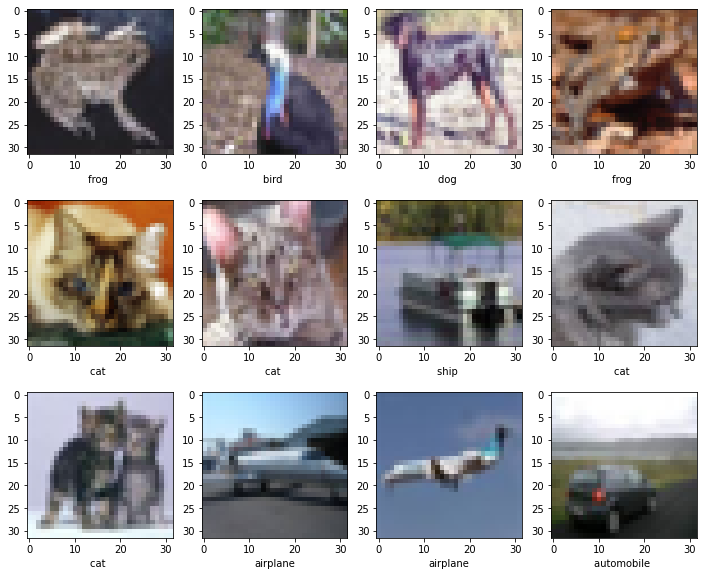

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Между тем, все нейросети инициализируются из расчёта, что входы будут распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент.

In [0]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [0]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
* принимает на вход картинки размера 32 x 32 x 3
* вытягивает их в вектор (`keras.layers.Flatten`)
* пропускает через 1-2 полносвязных слоя
* на выходе предсказывает отдает веротятности принадлежности к каждому из 10 классов

In [0]:
from keras.models import Sequential
from keras.layers import Activation, Dense, InputLayer, Flatten

import keras

In [0]:
# Создайте полносвязную сеть
model = Sequential()
model.add(InputLayer((32, 32, 3, )))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

In [0]:
dummy_pred = model.predict_proba(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


## Обучение сети

Будем оптимизировать категориальную коссэкнропию, которую будем минимизировать простым __sgd__. Вам нужно получить сеть, которая получит __accuracy__ на тестовых данных __не менее 45%__.

__Важно:__ поскольку в y_train лежат номера классов, керасу нужно либо указать sparse функции потерь и метрики (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать y в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекоммендуем [сохранять результаты](https://keras.io/callbacks/#tensorboard) в tensorboard.
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у карася есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или тюнер скорости обучения.

In [0]:
train_labels = keras.utils.to_categorical(y_train, len(class_names))
test_labels = keras.utils.to_categorical(y_test, len(class_names))
val_labels = keras.utils.to_categorical(y_val, len(class_names))

In [0]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=15, callbacks=my_callbacks)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 5s 119us/step - loss: 1.9109 - accuracy: 0.3138 - val_loss: 1.7894 - val_accuracy: 0.3713
Epoch 2/15
40000/40000 [==============================] - 5s 116us/step - loss: 1.7472 - accuracy: 0.3833 - val_loss: 1.7300 - val_accuracy: 0.3745
Epoch 3/15
40000/40000 [==============================] - 5s 115us/step - loss: 1.6759 - accuracy: 0.4089 - val_loss: 1.6519 - val_accuracy: 0.4102
Epoch 4/15
40000/40000 [==============================] - 5s 114us/step - loss: 1.6266 - accuracy: 0.4267 - val_loss: 1.6255 - val_accuracy: 0.4198
Epoch 5/15
40000/40000 [==============================] - 5s 114us/step - loss: 1.5855 - accuracy: 0.4405 - val_loss: 1.5959 - val_accuracy: 0.4385
Epoch 6/15
40000/40000 [==============================] - 5s 113us/step - loss: 1.5529 - accuracy: 0.4554 - val_loss: 1.5692 - val_accuracy: 0.4447
Epoch 7/15
40000/40000 [==============================] - 5s 1

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.4924
 Not bad!


## Карманная сверточная сеть

Реализуйте небольшую свёрточную сеть. Совсем небольшую:
* Входной слой
* Свёртка 3x3 с 10 фильтрами
* Нелинейность на ваш вкус
* Max-pooling 2x2
* Вытягиваем оставшееся в вектор (Flatten)
* Полносвязный слой на 100 нейронов
* Нелинейность на ваш вкус
* Выходной полносвязный слой с softmax

Обучите её также, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [0]:
from keras.layers import Conv2D, MaxPool2D

In [0]:
# создайте свёрточную сеть по инструкции выше
model = Sequential()
model.add(InputLayer((32, 32, 3,)))
model.add(Conv2D(filters=10, kernel_size=(3, 3,), activation='tanh'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

In [0]:
# Обучите модель
my_callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=7, callbacks=my_callbacks).history

Train on 40000 samples, validate on 10000 samples
Epoch 1/7
40000/40000 [==============================] - 7s 168us/step - loss: 1.9027 - accuracy: 0.3249 - val_loss: 1.7129 - val_accuracy: 0.3925
Epoch 2/7
40000/40000 [==============================] - 5s 133us/step - loss: 1.6371 - accuracy: 0.4240 - val_loss: 1.6164 - val_accuracy: 0.4309
Epoch 3/7
40000/40000 [==============================] - 5s 133us/step - loss: 1.5015 - accuracy: 0.4758 - val_loss: 1.4457 - val_accuracy: 0.4884
Epoch 4/7
40000/40000 [==============================] - 6s 141us/step - loss: 1.4014 - accuracy: 0.5072 - val_loss: 1.4123 - val_accuracy: 0.5028
Epoch 5/7
40000/40000 [==============================] - 6s 149us/step - loss: 1.3243 - accuracy: 0.5349 - val_loss: 1.3447 - val_accuracy: 0.5278
Epoch 6/7
40000/40000 [==============================] - 5s 137us/step - loss: 1.2632 - accuracy: 0.5570 - val_loss: 1.2940 - val_accuracy: 0.5442
Epoch 7/7
40000/40000 [==============================] - 5s 137us/st

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5565
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от времени обучения. 

Вам потребуется реализовать _экспериментальный стэнд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

In [0]:
from keras.optimizers import Adam, SGD

In [0]:
def fit_and_plot_results(model, opt, epochs, title, cv_scores) -> None:
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=epochs).history

  cv_scores[title] = history['val_accuracy']

  plt.title(title)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.plot(list(range(1, epochs + 1)), history['accuracy'], label='train')
  plt.plot(list(range(1, epochs + 1)), history['val_accuracy'], label='val')
  plt.legend()
  plt.show()

In [0]:
from keras import backend as K

def plot_experiment_stand(architecture, optimizers, epochs, cv_scores) -> None:
  for arch in architecture:
    for opt in optimizers:
      if opt == 'SGD':
        for momentum in np.linspace(0, 1, 11):
          model = Sequential(arch())
          fit_and_plot_results(model, SGD(momentum=momentum),
                               epochs, 'SGD: momentum = {}'.format(momentum), cv_scores)
          K.clear_session()
      elif opt == 'Adam':
        model = Sequential(arch())
        fit_and_plot_results(model, Adam(), epochs, 'Adam', cv_scores)
        K.clear_session()
      else:
        raise ValueError("Unexpected optimizer")

__Архитектура 1__

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 118us/step - loss: 1.9137 - accuracy: 0.3135 - val_loss: 1.8343 - val_accuracy: 0.3403
Epoch 2/30
40000/40000 [==============================] - 5s 116us/step - loss: 1.7749 - accuracy: 0.3656 - val_loss: 1.7671 - val_accuracy: 0.3598
Epoch 3/30
40000/40000 [==============================] - 5s 116us/step - loss: 1.7278 - accuracy: 0.3819 - val_loss: 1.7416 - val_accuracy: 0.3771
Epoch 4/30
40000/40000 [==============================] - 5s 116us/step - loss: 1.7006 - accuracy: 0.3933 - val_loss: 1.6992 - val_accuracy: 0.3959
Epoch 5/30
40000/40000 [==============================] - 5s 118us/step - loss: 1.6791 - accuracy: 0.4019 - val_loss: 1.6895 - val_accuracy: 0.3956
Epoch 6/30
40000/40000 [==============================] - 5s 117us/step - loss: 1.6687 - accuracy: 0.4055 - val_loss: 1.7078 - val_accuracy: 0.3929
Epoch 7/30
40000/40000 [==============================] - 5s 1

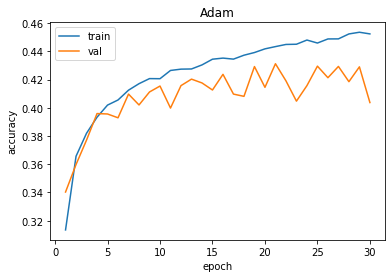

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.9238 - accuracy: 0.3125 - val_loss: 1.7940 - val_accuracy: 0.3712
Epoch 2/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.7511 - accuracy: 0.3832 - val_loss: 1.7317 - val_accuracy: 0.3887
Epoch 3/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.6756 - accuracy: 0.4119 - val_loss: 1.6482 - val_accuracy: 0.4174
Epoch 4/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.6226 - accuracy: 0.4315 - val_loss: 1.6163 - val_accuracy: 0.4291
Epoch 5/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.5826 - accuracy: 0.4474 - val_loss: 1.6295 - val_accuracy: 0.4194
Epoch 6/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.5460 - accuracy: 0.4579 - val_loss: 1.5931 - val_accuracy: 0.4380
Epoch 7/30
40000/40000 [==============================] - 4s 1

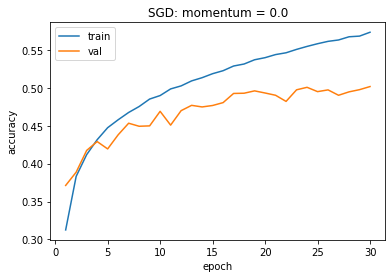

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 105us/step - loss: 1.9120 - accuracy: 0.3152 - val_loss: 1.7768 - val_accuracy: 0.3725
Epoch 2/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.7420 - accuracy: 0.3822 - val_loss: 1.6993 - val_accuracy: 0.3972
Epoch 3/30
40000/40000 [==============================] - 4s 112us/step - loss: 1.6661 - accuracy: 0.4113 - val_loss: 1.6465 - val_accuracy: 0.4172
Epoch 4/30
40000/40000 [==============================] - 5s 114us/step - loss: 1.6181 - accuracy: 0.4320 - val_loss: 1.6168 - val_accuracy: 0.4207
Epoch 5/30
40000/40000 [==============================] - 4s 108us/step - loss: 1.5777 - accuracy: 0.4453 - val_loss: 1.6008 - val_accuracy: 0.4276
Epoch 6/30
40000/40000 [==============================] - 4s 110us/step - loss: 1.5476 - accuracy: 0.4568 - val_loss: 1.5628 - val_accuracy: 0.4474
Epoch 7/30
40000/40000 [==============================] - 4s 1

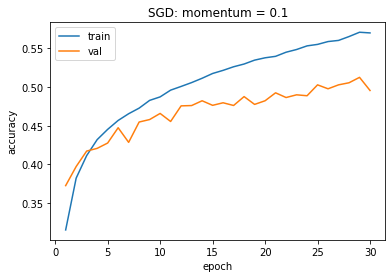

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.8992 - accuracy: 0.3208 - val_loss: 1.7797 - val_accuracy: 0.3660
Epoch 2/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.7267 - accuracy: 0.3892 - val_loss: 1.6913 - val_accuracy: 0.4011
Epoch 3/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.6549 - accuracy: 0.4155 - val_loss: 1.6395 - val_accuracy: 0.4214
Epoch 4/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.6043 - accuracy: 0.4331 - val_loss: 1.5897 - val_accuracy: 0.4394
Epoch 5/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.5663 - accuracy: 0.4502 - val_loss: 1.5757 - val_accuracy: 0.4463
Epoch 6/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.5334 - accuracy: 0.4612 - val_loss: 1.5766 - val_accuracy: 0.4421
Epoch 7/30
40000/40000 [==============================] - 4s 1

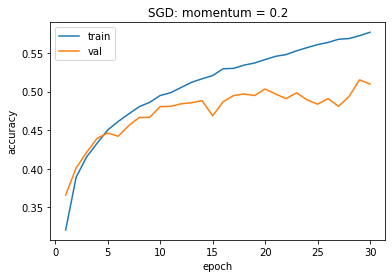

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 105us/step - loss: 1.8966 - accuracy: 0.3216 - val_loss: 1.7616 - val_accuracy: 0.3674
Epoch 2/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.7248 - accuracy: 0.3896 - val_loss: 1.6694 - val_accuracy: 0.4118
Epoch 3/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.6449 - accuracy: 0.4189 - val_loss: 1.6259 - val_accuracy: 0.4288
Epoch 4/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.5956 - accuracy: 0.4371 - val_loss: 1.5794 - val_accuracy: 0.4444
Epoch 5/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.5570 - accuracy: 0.4507 - val_loss: 1.5946 - val_accuracy: 0.4334
Epoch 6/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.5242 - accuracy: 0.4625 - val_loss: 1.5532 - val_accuracy: 0.4532
Epoch 7/30
40000/40000 [==============================] - 4s 1

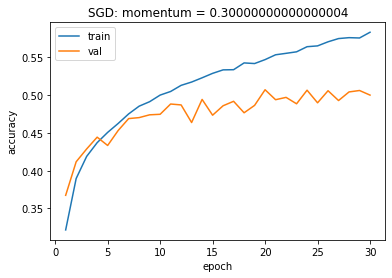

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 104us/step - loss: 1.8840 - accuracy: 0.3251 - val_loss: 1.7433 - val_accuracy: 0.3739
Epoch 2/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.7110 - accuracy: 0.3959 - val_loss: 1.6537 - val_accuracy: 0.4170
Epoch 3/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.6377 - accuracy: 0.4228 - val_loss: 1.6442 - val_accuracy: 0.4150
Epoch 4/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.5886 - accuracy: 0.4392 - val_loss: 1.6075 - val_accuracy: 0.4246
Epoch 5/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.5504 - accuracy: 0.4527 - val_loss: 1.5521 - val_accuracy: 0.4466
Epoch 6/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.5149 - accuracy: 0.4655 - val_loss: 1.5399 - val_accuracy: 0.4566
Epoch 7/30
40000/40000 [==============================] - 4s 1

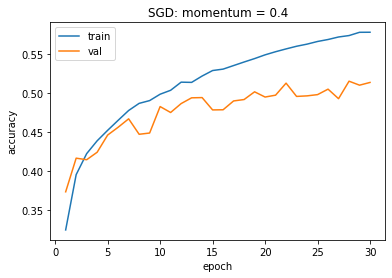

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 104us/step - loss: 1.8833 - accuracy: 0.3242 - val_loss: 1.7636 - val_accuracy: 0.3749
Epoch 2/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.7043 - accuracy: 0.3961 - val_loss: 1.6522 - val_accuracy: 0.4167
Epoch 3/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.6319 - accuracy: 0.4226 - val_loss: 1.6278 - val_accuracy: 0.4236
Epoch 4/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.5813 - accuracy: 0.4407 - val_loss: 1.5880 - val_accuracy: 0.4415
Epoch 5/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.5415 - accuracy: 0.4557 - val_loss: 1.5798 - val_accuracy: 0.4393
Epoch 6/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.5079 - accuracy: 0.4649 - val_loss: 1.5634 - val_accuracy: 0.4452
Epoch 7/30
40000/40000 [==============================] - 4s 1

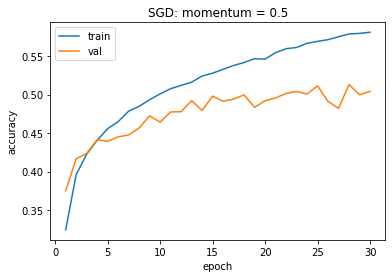

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 104us/step - loss: 1.8784 - accuracy: 0.3237 - val_loss: 1.7472 - val_accuracy: 0.3746
Epoch 2/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.7002 - accuracy: 0.3961 - val_loss: 1.6529 - val_accuracy: 0.4109
Epoch 3/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.6279 - accuracy: 0.4216 - val_loss: 1.5989 - val_accuracy: 0.4259
Epoch 4/30
40000/40000 [==============================] - 5s 117us/step - loss: 1.5755 - accuracy: 0.4435 - val_loss: 1.5626 - val_accuracy: 0.4463
Epoch 5/30
40000/40000 [==============================] - 5s 117us/step - loss: 1.5386 - accuracy: 0.4553 - val_loss: 1.6700 - val_accuracy: 0.4221
Epoch 6/30
40000/40000 [==============================] - 4s 107us/step - loss: 1.5084 - accuracy: 0.4677 - val_loss: 1.5313 - val_accuracy: 0.4593
Epoch 7/30
40000/40000 [==============================] - 4s 1

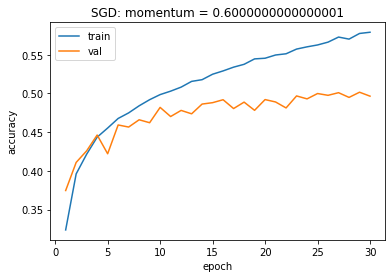

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.8712 - accuracy: 0.3279 - val_loss: 1.7754 - val_accuracy: 0.3529
Epoch 2/30
40000/40000 [==============================] - 4s 101us/step - loss: 1.6990 - accuracy: 0.3940 - val_loss: 1.6662 - val_accuracy: 0.4096
Epoch 3/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.6273 - accuracy: 0.4231 - val_loss: 1.6177 - val_accuracy: 0.4331
Epoch 4/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.5850 - accuracy: 0.4363 - val_loss: 1.6673 - val_accuracy: 0.4089
Epoch 5/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.5478 - accuracy: 0.4511 - val_loss: 1.5749 - val_accuracy: 0.4373
Epoch 6/30
40000/40000 [==============================] - 4s 99us/step - loss: 1.5153 - accuracy: 0.4630 - val_loss: 1.5201 - val_accuracy: 0.4585
Epoch 7/30
40000/40000 [==============================] - 4s 10

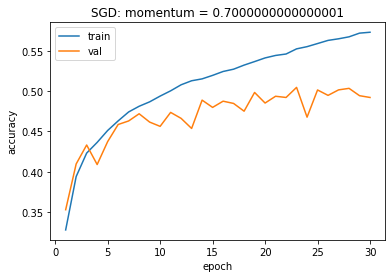

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 104us/step - loss: 1.8711 - accuracy: 0.3242 - val_loss: 1.7778 - val_accuracy: 0.3698
Epoch 2/30
40000/40000 [==============================] - 4s 103us/step - loss: 1.7093 - accuracy: 0.3869 - val_loss: 1.6768 - val_accuracy: 0.4033
Epoch 3/30
40000/40000 [==============================] - 4s 104us/step - loss: 1.6488 - accuracy: 0.4124 - val_loss: 1.6207 - val_accuracy: 0.4214
Epoch 4/30
40000/40000 [==============================] - 4s 104us/step - loss: 1.6043 - accuracy: 0.4306 - val_loss: 1.6639 - val_accuracy: 0.4098
Epoch 5/30
40000/40000 [==============================] - 4s 106us/step - loss: 1.5757 - accuracy: 0.4382 - val_loss: 1.6187 - val_accuracy: 0.4322
Epoch 6/30
40000/40000 [==============================] - 4s 106us/step - loss: 1.5446 - accuracy: 0.4514 - val_loss: 1.5806 - val_accuracy: 0.4385
Epoch 7/30
40000/40000 [==============================] - 4s 1

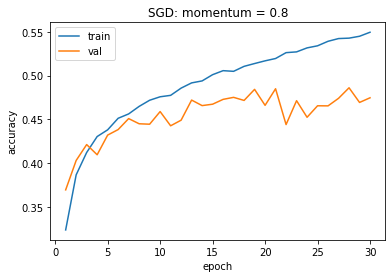

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 102us/step - loss: 1.9588 - accuracy: 0.2779 - val_loss: 1.9249 - val_accuracy: 0.2943
Epoch 2/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.8564 - accuracy: 0.3209 - val_loss: 1.8498 - val_accuracy: 0.3265
Epoch 3/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.8111 - accuracy: 0.3364 - val_loss: 1.8378 - val_accuracy: 0.3273
Epoch 4/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.7724 - accuracy: 0.3545 - val_loss: 1.7591 - val_accuracy: 0.3637
Epoch 5/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.7454 - accuracy: 0.3675 - val_loss: 1.7555 - val_accuracy: 0.3684
Epoch 6/30
40000/40000 [==============================] - 4s 100us/step - loss: 1.7257 - accuracy: 0.3746 - val_loss: 1.7468 - val_accuracy: 0.3698
Epoch 7/30
40000/40000 [==============================] - 4s 1

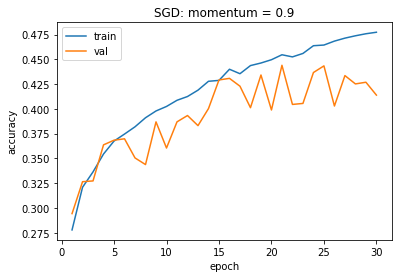

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 104us/step - loss: 2.3822 - accuracy: 0.1073 - val_loss: 2.4451 - val_accuracy: 0.0972
Epoch 2/30
40000/40000 [==============================] - 4s 103us/step - loss: 2.4333 - accuracy: 0.1016 - val_loss: 2.4905 - val_accuracy: 0.0979
Epoch 3/30
40000/40000 [==============================] - 4s 105us/step - loss: 2.5348 - accuracy: 0.0988 - val_loss: 2.7239 - val_accuracy: 0.0933
Epoch 4/30
40000/40000 [==============================] - 4s 105us/step - loss: 2.6552 - accuracy: 0.1004 - val_loss: 2.8754 - val_accuracy: 0.0979
Epoch 5/30
40000/40000 [==============================] - 4s 105us/step - loss: 2.7745 - accuracy: 0.1014 - val_loss: 3.0491 - val_accuracy: 0.1015
Epoch 6/30
40000/40000 [==============================] - 4s 103us/step - loss: 2.9585 - accuracy: 0.0973 - val_loss: 2.7062 - val_accuracy: 0.0933
Epoch 7/30
40000/40000 [==============================] - 4s 1

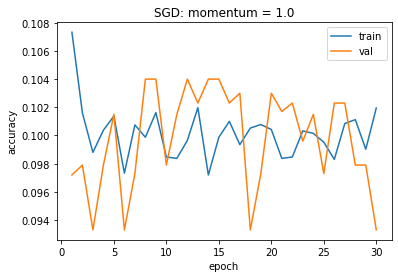

In [0]:
def make_arch1():
  return [InputLayer((32, 32, 3, )),
          Flatten(),
          Dense(128, activation='relu'),
          Dense(len(class_names), activation='softmax')]

K.clear_session()
cv_scores_1 = {}
plot_experiment_stand([make_arch1,], ['Adam', 'SGD'], 30, cv_scores_1)

Для первой построенной архитектуры лучше всего с точки зрения обучащей кривой является метод оптимизации Адам, но у него хуже accuracy, чем у SGD. Также можно заметить, кривая обучения при валидации SGD c momentum 0.9 лучше подходит к обучающей кривой, однако значение accuracy (как было сказано) меньше.

__Архитектура 2__

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 6s 143us/step - loss: 1.5478 - accuracy: 0.4546 - val_loss: 1.3273 - val_accuracy: 0.5321
Epoch 2/30
40000/40000 [==============================] - 6s 147us/step - loss: 1.2236 - accuracy: 0.5725 - val_loss: 1.2435 - val_accuracy: 0.5641
Epoch 3/30
40000/40000 [==============================] - 6s 149us/step - loss: 1.0549 - accuracy: 0.6326 - val_loss: 1.1438 - val_accuracy: 0.6003
Epoch 4/30
40000/40000 [==============================] - 6s 155us/step - loss: 0.9306 - accuracy: 0.6768 - val_loss: 1.1721 - val_accuracy: 0.5977
Epoch 5/30
40000/40000 [==============================] - 6s 140us/step - loss: 0.8272 - accuracy: 0.7142 - val_loss: 1.1482 - val_accuracy: 0.6129
Epoch 6/30
40000/40000 [==============================] - 6s 138us/step - loss: 0.7377 - accuracy: 0.7453 - val_loss: 1.1603 - val_accuracy: 0.6126
Epoch 7/30
40000/40000 [==============================] - 6s 1

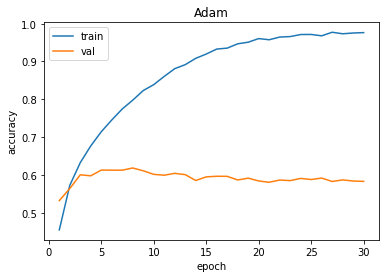

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 122us/step - loss: 1.9086 - accuracy: 0.3203 - val_loss: 1.7288 - val_accuracy: 0.3908
Epoch 2/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.6467 - accuracy: 0.4189 - val_loss: 1.5705 - val_accuracy: 0.4463
Epoch 3/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.5147 - accuracy: 0.4666 - val_loss: 1.4789 - val_accuracy: 0.4824
Epoch 4/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.4118 - accuracy: 0.5040 - val_loss: 1.4122 - val_accuracy: 0.5020
Epoch 5/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.3312 - accuracy: 0.5311 - val_loss: 1.3380 - val_accuracy: 0.5274
Epoch 6/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.2690 - accuracy: 0.5545 - val_loss: 1.3216 - val_accuracy: 0.5393
Epoch 7/30
40000/40000 [==============================] - 5s 1

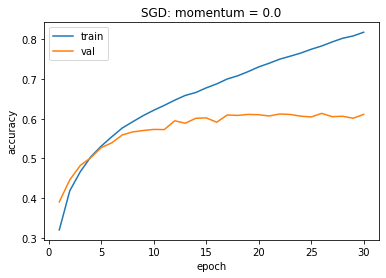

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 124us/step - loss: 1.8867 - accuracy: 0.3307 - val_loss: 1.7124 - val_accuracy: 0.3868
Epoch 2/30
40000/40000 [==============================] - 5s 125us/step - loss: 1.6347 - accuracy: 0.4255 - val_loss: 1.6238 - val_accuracy: 0.4266
Epoch 3/30
40000/40000 [==============================] - 6s 138us/step - loss: 1.5067 - accuracy: 0.4697 - val_loss: 1.5116 - val_accuracy: 0.4589
Epoch 4/30
40000/40000 [==============================] - 5s 131us/step - loss: 1.4128 - accuracy: 0.5052 - val_loss: 1.3792 - val_accuracy: 0.5140
Epoch 5/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.3332 - accuracy: 0.5340 - val_loss: 1.3376 - val_accuracy: 0.5283
Epoch 6/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.2686 - accuracy: 0.5588 - val_loss: 1.3065 - val_accuracy: 0.5369
Epoch 7/30
40000/40000 [==============================] - 5s 1

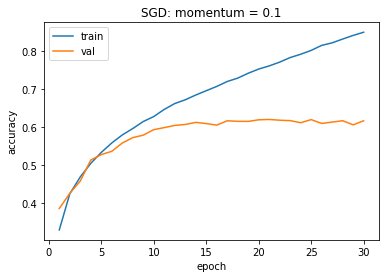

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 123us/step - loss: 1.8473 - accuracy: 0.3447 - val_loss: 1.6714 - val_accuracy: 0.4085
Epoch 2/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.5910 - accuracy: 0.4390 - val_loss: 1.5155 - val_accuracy: 0.4608
Epoch 3/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.4464 - accuracy: 0.4923 - val_loss: 1.4185 - val_accuracy: 0.4980
Epoch 4/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.3393 - accuracy: 0.5286 - val_loss: 1.3310 - val_accuracy: 0.5297
Epoch 5/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.2571 - accuracy: 0.5583 - val_loss: 1.2852 - val_accuracy: 0.5463
Epoch 6/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.1917 - accuracy: 0.5835 - val_loss: 1.2821 - val_accuracy: 0.5500
Epoch 7/30
40000/40000 [==============================] - 5s 1

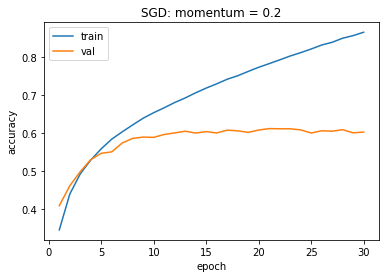

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 124us/step - loss: 1.8415 - accuracy: 0.3448 - val_loss: 1.6689 - val_accuracy: 0.3985
Epoch 2/30
40000/40000 [==============================] - 5s 128us/step - loss: 1.5571 - accuracy: 0.4482 - val_loss: 1.4757 - val_accuracy: 0.4744
Epoch 3/30
40000/40000 [==============================] - 5s 127us/step - loss: 1.4155 - accuracy: 0.4974 - val_loss: 1.4189 - val_accuracy: 0.4921
Epoch 4/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.3127 - accuracy: 0.5392 - val_loss: 1.3378 - val_accuracy: 0.5257
Epoch 5/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.2342 - accuracy: 0.5649 - val_loss: 1.2564 - val_accuracy: 0.5560
Epoch 6/30
40000/40000 [==============================] - 5s 130us/step - loss: 1.1704 - accuracy: 0.5905 - val_loss: 1.2328 - val_accuracy: 0.5703
Epoch 7/30
40000/40000 [==============================] - 5s 1

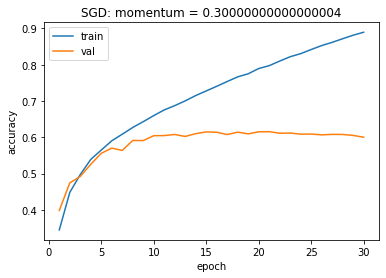

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 122us/step - loss: 1.8325 - accuracy: 0.3480 - val_loss: 1.7023 - val_accuracy: 0.4014
Epoch 2/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.5365 - accuracy: 0.4631 - val_loss: 1.4696 - val_accuracy: 0.4822
Epoch 3/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.3989 - accuracy: 0.5077 - val_loss: 1.3749 - val_accuracy: 0.5198
Epoch 4/30
40000/40000 [==============================] - 5s 124us/step - loss: 1.2988 - accuracy: 0.5466 - val_loss: 1.3076 - val_accuracy: 0.5402
Epoch 5/30
40000/40000 [==============================] - 5s 124us/step - loss: 1.2204 - accuracy: 0.5735 - val_loss: 1.2452 - val_accuracy: 0.5630
Epoch 6/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.1475 - accuracy: 0.5957 - val_loss: 1.2538 - val_accuracy: 0.5666
Epoch 7/30
40000/40000 [==============================] - 5s 1

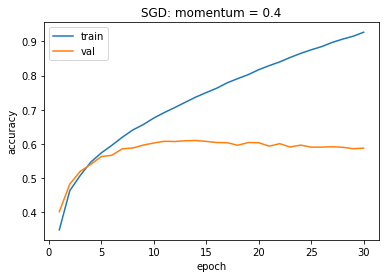

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 124us/step - loss: 1.8042 - accuracy: 0.3590 - val_loss: 1.5783 - val_accuracy: 0.4350
Epoch 2/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.4952 - accuracy: 0.4753 - val_loss: 1.4453 - val_accuracy: 0.4831
Epoch 3/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.3459 - accuracy: 0.5263 - val_loss: 1.3906 - val_accuracy: 0.5042
Epoch 4/30
40000/40000 [==============================] - 5s 123us/step - loss: 1.2414 - accuracy: 0.5657 - val_loss: 1.2614 - val_accuracy: 0.5573
Epoch 5/30
40000/40000 [==============================] - 5s 130us/step - loss: 1.1578 - accuracy: 0.5957 - val_loss: 1.2347 - val_accuracy: 0.5655
Epoch 6/30
40000/40000 [==============================] - 5s 122us/step - loss: 1.0906 - accuracy: 0.6192 - val_loss: 1.1916 - val_accuracy: 0.5870
Epoch 7/30
40000/40000 [==============================] - 5s 1

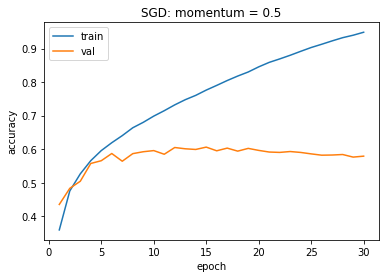

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 122us/step - loss: 1.7621 - accuracy: 0.3743 - val_loss: 1.5544 - val_accuracy: 0.4379
Epoch 2/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.4535 - accuracy: 0.4877 - val_loss: 1.3902 - val_accuracy: 0.5100
Epoch 3/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.3034 - accuracy: 0.5407 - val_loss: 1.3116 - val_accuracy: 0.5352
Epoch 4/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.1915 - accuracy: 0.5809 - val_loss: 1.2238 - val_accuracy: 0.5721
Epoch 5/30
40000/40000 [==============================] - 5s 120us/step - loss: 1.1067 - accuracy: 0.6162 - val_loss: 1.1789 - val_accuracy: 0.5871
Epoch 6/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.0244 - accuracy: 0.6435 - val_loss: 1.1730 - val_accuracy: 0.5868
Epoch 7/30
40000/40000 [==============================] - 5s 1

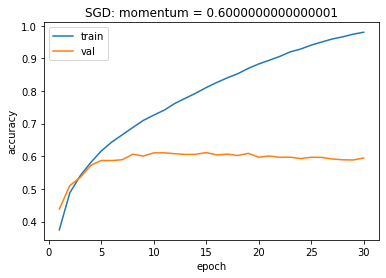

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 123us/step - loss: 1.7256 - accuracy: 0.3816 - val_loss: 1.4819 - val_accuracy: 0.4663
Epoch 2/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.3997 - accuracy: 0.5058 - val_loss: 1.4180 - val_accuracy: 0.4917
Epoch 3/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.2466 - accuracy: 0.5635 - val_loss: 1.3010 - val_accuracy: 0.5430
Epoch 4/30
40000/40000 [==============================] - 5s 122us/step - loss: 1.1379 - accuracy: 0.5995 - val_loss: 1.2544 - val_accuracy: 0.5528
Epoch 5/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.0501 - accuracy: 0.6309 - val_loss: 1.1857 - val_accuracy: 0.5869
Epoch 6/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.9756 - accuracy: 0.6593 - val_loss: 1.1790 - val_accuracy: 0.5924
Epoch 7/30
40000/40000 [==============================] - 5s 1

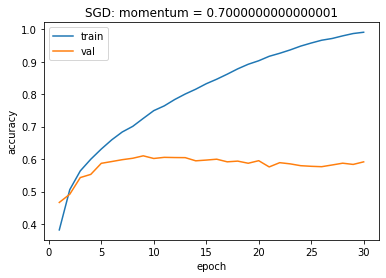

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 124us/step - loss: 1.6767 - accuracy: 0.4003 - val_loss: 1.4578 - val_accuracy: 0.4749
Epoch 2/30
40000/40000 [==============================] - 5s 123us/step - loss: 1.3294 - accuracy: 0.5276 - val_loss: 1.3363 - val_accuracy: 0.5282
Epoch 3/30
40000/40000 [==============================] - 5s 123us/step - loss: 1.1678 - accuracy: 0.5883 - val_loss: 1.2264 - val_accuracy: 0.5623
Epoch 4/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.0543 - accuracy: 0.6285 - val_loss: 1.1580 - val_accuracy: 0.5951
Epoch 5/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.9589 - accuracy: 0.6635 - val_loss: 1.1968 - val_accuracy: 0.5801
Epoch 6/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.8743 - accuracy: 0.6933 - val_loss: 1.2078 - val_accuracy: 0.5916
Epoch 7/30
40000/40000 [==============================] - 5s 1

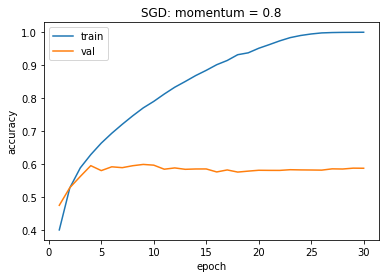

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 123us/step - loss: 1.6104 - accuracy: 0.4270 - val_loss: 1.4057 - val_accuracy: 0.5014
Epoch 2/30
40000/40000 [==============================] - 5s 125us/step - loss: 1.2989 - accuracy: 0.5398 - val_loss: 1.2748 - val_accuracy: 0.5529
Epoch 3/30
40000/40000 [==============================] - 5s 123us/step - loss: 1.1482 - accuracy: 0.5957 - val_loss: 1.2158 - val_accuracy: 0.5787
Epoch 4/30
40000/40000 [==============================] - 5s 121us/step - loss: 1.0313 - accuracy: 0.6383 - val_loss: 1.2365 - val_accuracy: 0.5790
Epoch 5/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.9262 - accuracy: 0.6754 - val_loss: 1.2896 - val_accuracy: 0.5789
Epoch 6/30
40000/40000 [==============================] - 5s 121us/step - loss: 0.8379 - accuracy: 0.7056 - val_loss: 1.4354 - val_accuracy: 0.5696
Epoch 7/30
40000/40000 [==============================] - 5s 1

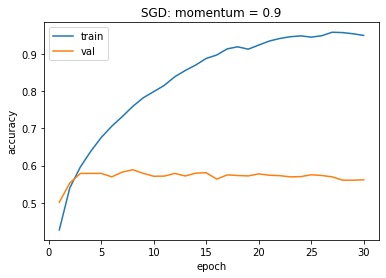

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 5s 123us/step - loss: 2.3343 - accuracy: 0.1084 - val_loss: 2.3556 - val_accuracy: 0.0996
Epoch 2/30
40000/40000 [==============================] - 5s 121us/step - loss: 2.4433 - accuracy: 0.1001 - val_loss: 2.5514 - val_accuracy: 0.0979
Epoch 3/30
40000/40000 [==============================] - 5s 122us/step - loss: 2.5831 - accuracy: 0.1017 - val_loss: 2.5830 - val_accuracy: 0.0979
Epoch 4/30
40000/40000 [==============================] - 5s 123us/step - loss: 2.5714 - accuracy: 0.1024 - val_loss: 2.4919 - val_accuracy: 0.0996
Epoch 5/30
40000/40000 [==============================] - 5s 125us/step - loss: 2.6260 - accuracy: 0.0989 - val_loss: 2.6022 - val_accuracy: 0.1023
Epoch 6/30
40000/40000 [==============================] - 5s 122us/step - loss: 2.5857 - accuracy: 0.0994 - val_loss: 2.6312 - val_accuracy: 0.0933
Epoch 7/30
40000/40000 [==============================] - 5s 1

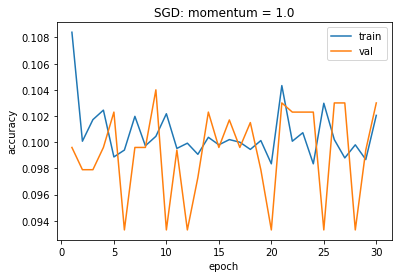

In [0]:
def make_arch2():
  return [InputLayer((32, 32, 3,)),
          Conv2D(filters=10, kernel_size=(3, 3,), activation='tanh'),
          MaxPool2D(),
          Flatten(),
          Dense(100, activation='relu'),
          Dense(len(class_names), activation='softmax')]

K.clear_session()
cv_scores_2 = {}
plot_experiment_stand([make_arch2,], ['Adam', 'SGD'], 30, cv_scores_2)

Для второй построенной архитектуры лучше всего с точки зрения обучащей кривой является метод оптимизации SGD с momentum, близким к 0 (в этом случае значение метрики accuracy на обучении и валидации не сильно расходятся). При momentum близких к 1 переобучение начинается на более ранних эпохах.

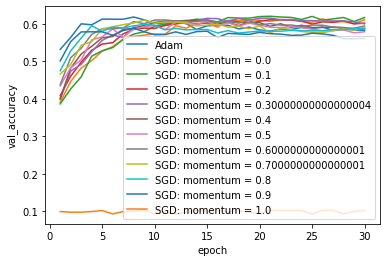

In [0]:
for key in cv_scores_1.keys():
  plt.xlabel('epoch')
  plt.ylabel('val_accuracy')
  plt.plot(list(range(1,31)), cv_scores_2[key], label=key)
  plt.plot()

  plt.legend()

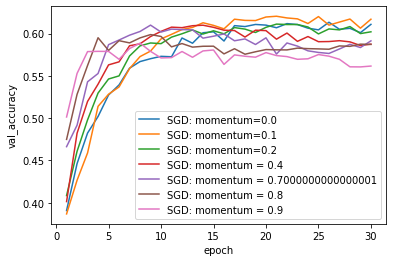

In [0]:
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.plot(list(range(1,31)), cv_scores_2['SGD: momentum = 0.0'], label='SGD: momentum=0.0')
plt.plot(list(range(1,31)), cv_scores_2['SGD: momentum = 0.1'], label='SGD: momentum=0.1')
plt.plot(list(range(1,31)), cv_scores_2['SGD: momentum = 0.2'], label='SGD: momentum=0.2')
plt.plot(list(range(1,31)), cv_scores_2['SGD: momentum = 0.4'], label='SGD: momentum = 0.4')
plt.plot(list(range(1,31)), cv_scores_2['SGD: momentum = 0.7000000000000001'], label='SGD: momentum = 0.7000000000000001')
plt.plot(list(range(1,31)), cv_scores_2['SGD: momentum = 0.8'], label='SGD: momentum = 0.8')
plt.plot(list(range(1,31)), cv_scores_2['SGD: momentum = 0.9'], label='SGD: momentum = 0.9')
plt.plot()
plt.legend()

__Вывод:__ Нет каких-то общий рекомендаций, что один метод обучения лучше другого (видно на примере построенных архитектур). Однако в обоих случаях при увеличении momentum качество на эпохе падает, а при равным 1 кривые начинает трясти и маленькое качество.

Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.




In [0]:
from keras.layers import BatchNormalization

In [0]:
model = Sequential()

model.add(InputLayer((32, 32, 3,)))
model.add(Conv2D(filters=10, kernel_size=(3, 3,)))
model.add(Activation('tanh'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.1), metrics=['accuracy'])
history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=10).history

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 150us/step - loss: 1.7005 - accuracy: 0.4058 - val_loss: 1.5599 - val_accuracy: 0.4586
Epoch 2/10
40000/40000 [==============================] - 6s 145us/step - loss: 1.4596 - accuracy: 0.4966 - val_loss: 1.5394 - val_accuracy: 0.4609
Epoch 3/10
40000/40000 [==============================] - 6s 145us/step - loss: 1.3379 - accuracy: 0.5383 - val_loss: 1.3828 - val_accuracy: 0.5160
Epoch 4/10
40000/40000 [==============================] - 6s 145us/step - loss: 1.2477 - accuracy: 0.5681 - val_loss: 1.7688 - val_accuracy: 0.4060
Epoch 5/10
40000/40000 [==============================] - 6s 146us/step - loss: 1.1772 - accuracy: 0.5911 - val_loss: 2.7521 - val_accuracy: 0.2366
Epoch 6/10
40000/40000 [==============================] - 6s 148us/step - loss: 1.1075 - accuracy: 0.6165 - val_loss: 1.4452 - val_accuracy: 0.5043
Epoch 7/10
40000/40000 [==============================] - 6s 1

Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%.

In [0]:
model = Sequential()

model.add(InputLayer((32, 32, 3,)))
model.add(Conv2D(filters=10, kernel_size=(3, 3,)))
model.add(Activation('tanh'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.1), metrics=['accuracy'])
history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=10, batch_size=80).history

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 75us/step - loss: 1.8166 - accuracy: 0.3681 - val_loss: 1.6919 - val_accuracy: 0.4078
Epoch 2/10
40000/40000 [==============================] - 3s 69us/step - loss: 1.5922 - accuracy: 0.4569 - val_loss: 1.6636 - val_accuracy: 0.4207
Epoch 3/10
40000/40000 [==============================] - 3s 69us/step - loss: 1.4911 - accuracy: 0.4924 - val_loss: 1.5943 - val_accuracy: 0.4506
Epoch 4/10
40000/40000 [==============================] - 3s 70us/step - loss: 1.4094 - accuracy: 0.5229 - val_loss: 1.4942 - val_accuracy: 0.4704
Epoch 5/10
40000/40000 [==============================] - 3s 69us/step - loss: 1.3375 - accuracy: 0.5462 - val_loss: 1.4284 - val_accuracy: 0.5001
Epoch 6/10
40000/40000 [==============================] - 3s 70us/step - loss: 1.2732 - accuracy: 0.5693 - val_loss: 1.6627 - val_accuracy: 0.4380
Epoch 7/10
40000/40000 [==============================] - 3s 69us/st

В этом пункте я старалась найти batch_size такой, чтобы:  
1) значение accuracy на обучении и валидации не сильно отличалось  
2) такой batch_size был минимальным  

В основном 55% было на 7-9 эпохах, но batch_size сильно отличался от используемых методов оптимизации. При увеличении momentum batch_size увеличивался; при Адаме, к сожалению, не удалось найти нужного значения

Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения.

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 3s 64us/step - loss: 1.9138 - accuracy: 0.3245 - val_loss: 2.0103 - val_accuracy: 0.3274
Epoch 2/20
40000/40000 [==============================] - 2s 53us/step - loss: 1.7095 - accuracy: 0.4117 - val_loss: 1.7636 - val_accuracy: 0.4030
Epoch 3/20
40000/40000 [==============================] - 2s 52us/step - loss: 1.6310 - accuracy: 0.4445 - val_loss: 1.6473 - val_accuracy: 0.4446
Epoch 4/20
40000/40000 [==============================] - 2s 52us/step - loss: 1.5735 - accuracy: 0.4672 - val_loss: 1.5992 - val_accuracy: 0.4496
Epoch 5/20
40000/40000 [==============================] - 2s 50us/step - loss: 1.5254 - accuracy: 0.4845 - val_loss: 1.5980 - val_accuracy: 0.4419
Epoch 6/20
40000/40000 [==============================] - 2s 49us/step - loss: 1.4849 - accuracy: 0.4997 - val_loss: 1.5102 - val_accuracy: 0.4806
Epoch 7/20
40000/40000 [==============================] - 2s 49us/st

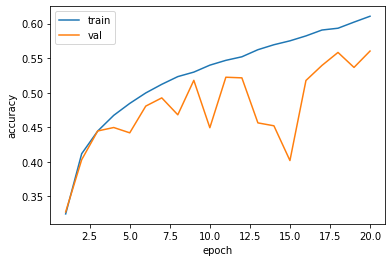

In [0]:
# A WHOLE LOT OF YOUR CODE
model = Sequential()

model.add(InputLayer((32, 32, 3,)))
model.add(Conv2D(filters=10, kernel_size=(3, 3,)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dense(len(class_names)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

epochs=20

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.0), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=epochs, batch_size=200).history

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(list(range(1, epochs + 1)), history['accuracy'], label='train')
plt.plot(list(range(1, epochs + 1)), history['val_accuracy'], label='val')
plt.legend()
plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 2s 40us/step - loss: 2.0104 - accuracy: 0.2911 - val_loss: 2.1949 - val_accuracy: 0.1513
Epoch 2/40
40000/40000 [==============================] - 1s 35us/step - loss: 1.7775 - accuracy: 0.3914 - val_loss: 2.0502 - val_accuracy: 0.3277
Epoch 3/40
40000/40000 [==============================] - 1s 35us/step - loss: 1.7073 - accuracy: 0.4234 - val_loss: 1.8728 - val_accuracy: 0.4185
Epoch 4/40
40000/40000 [==============================] - 1s 35us/step - loss: 1.6590 - accuracy: 0.4441 - val_loss: 1.7728 - val_accuracy: 0.3921
Epoch 5/40
40000/40000 [==============================] - 1s 35us/step - loss: 1.6182 - accuracy: 0.4598 - val_loss: 1.6487 - val_accuracy: 0.4436
Epoch 6/40
40000/40000 [==============================] - 1s 35us/step - loss: 1.5842 - accuracy: 0.4711 - val_loss: 1.6281 - val_accuracy: 0.4494
Epoch 7/40
40000/40000 [==============================] - 1s 35us/st

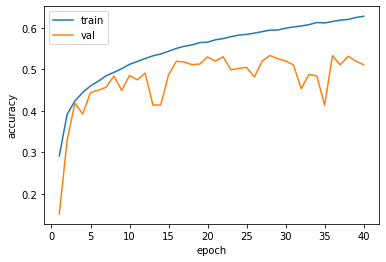

In [0]:
model = Sequential()

model.add(InputLayer((32, 32, 3,)))
model.add(Conv2D(filters=10, kernel_size=(3, 3,)))
model.add(Activation('tanh'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dense(len(class_names)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

epochs=40

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.0), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=epochs, batch_size=300).history

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(list(range(1, epochs + 1)), history['accuracy'], label='train')
plt.plot(list(range(1, epochs + 1)), history['val_accuracy'], label='val')
plt.legend()
plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 1s 37us/step - loss: 2.0344 - accuracy: 0.2743 - val_loss: 2.2658 - val_accuracy: 0.1228
Epoch 2/40
40000/40000 [==============================] - 1s 32us/step - loss: 1.8169 - accuracy: 0.3689 - val_loss: 2.1408 - val_accuracy: 0.2294
Epoch 3/40
40000/40000 [==============================] - 1s 31us/step - loss: 1.7487 - accuracy: 0.4011 - val_loss: 1.9970 - val_accuracy: 0.3587
Epoch 4/40
40000/40000 [==============================] - 1s 32us/step - loss: 1.7074 - accuracy: 0.4216 - val_loss: 1.8600 - val_accuracy: 0.4075
Epoch 5/40
40000/40000 [==============================] - 1s 32us/step - loss: 1.6763 - accuracy: 0.4346 - val_loss: 1.7448 - val_accuracy: 0.4230
Epoch 6/40
40000/40000 [==============================] - 1s 32us/step - loss: 1.6495 - accuracy: 0.4448 - val_loss: 1.6795 - val_accuracy: 0.4423
Epoch 7/40
40000/40000 [==============================] - 1s 32us/st

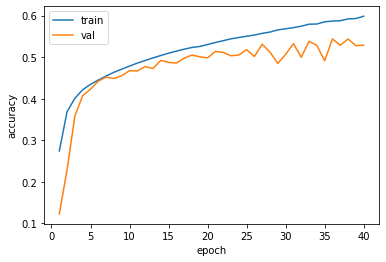

In [0]:
model = Sequential()

model.add(InputLayer((32, 32, 3,)))
model.add(Conv2D(filters=10, kernel_size=(3, 3,)))
model.add(Activation('tanh'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dense(len(class_names)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

epochs=40

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.0), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=epochs, batch_size=400).history

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(list(range(1, epochs + 1)), history['accuracy'], label='train')
plt.plot(list(range(1, epochs + 1)), history['val_accuracy'], label='val')
plt.legend()
plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 1s 35us/step - loss: 2.0358 - accuracy: 0.2735 - val_loss: 2.4029 - val_accuracy: 0.1890
Epoch 2/50
40000/40000 [==============================] - 1s 30us/step - loss: 1.8536 - accuracy: 0.3571 - val_loss: 2.2411 - val_accuracy: 0.2313
Epoch 3/50
40000/40000 [==============================] - 1s 30us/step - loss: 1.7920 - accuracy: 0.3857 - val_loss: 2.1070 - val_accuracy: 0.2733
Epoch 4/50
40000/40000 [==============================] - 1s 30us/step - loss: 1.7505 - accuracy: 0.4043 - val_loss: 1.9927 - val_accuracy: 0.3416
Epoch 5/50
40000/40000 [==============================] - 1s 31us/step - loss: 1.7178 - accuracy: 0.4203 - val_loss: 1.8830 - val_accuracy: 0.3942
Epoch 6/50
40000/40000 [==============================] - 1s 30us/step - loss: 1.6907 - accuracy: 0.4301 - val_loss: 1.7935 - val_accuracy: 0.4138
Epoch 7/50
40000/40000 [==============================] - 1s 30us/st

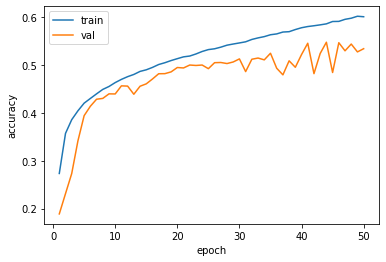

In [0]:
model = Sequential()

model.add(InputLayer((32, 32, 3,)))
model.add(Conv2D(filters=10, kernel_size=(3, 3,)))
model.add(Activation('tanh'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dense(len(class_names)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

epochs=50

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.0), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=epochs, batch_size=500).history

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(list(range(1, epochs + 1)), history['accuracy'], label='train')
plt.plot(list(range(1, epochs + 1)), history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [0]:
model = Sequential()

model.add(InputLayer((32, 32, 3,)))
model.add(Conv2D(filters=10, kernel_size=(3, 3,)))
model.add(Activation('tanh'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dense(len(class_names)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

epochs=80

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.0), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=epochs, batch_size=1000).history

Train on 40000 samples, validate on 10000 samples
Epoch 1/80
40000/40000 [==============================] - 1s 32us/step - loss: 2.1703 - accuracy: 0.2194 - val_loss: 2.3509 - val_accuracy: 0.1041
Epoch 2/80
40000/40000 [==============================] - 1s 25us/step - loss: 1.9529 - accuracy: 0.3092 - val_loss: 2.2856 - val_accuracy: 0.1066
Epoch 3/80
40000/40000 [==============================] - 1s 25us/step - loss: 1.8794 - accuracy: 0.3438 - val_loss: 2.2368 - val_accuracy: 0.1161
Epoch 4/80
40000/40000 [==============================] - 1s 25us/step - loss: 1.8317 - accuracy: 0.3658 - val_loss: 2.1932 - val_accuracy: 0.1453
Epoch 5/80
40000/40000 [==============================] - 1s 25us/step - loss: 1.7974 - accuracy: 0.3801 - val_loss: 2.1439 - val_accuracy: 0.1948
Epoch 6/80
40000/40000 [==============================] - 1s 25us/step - loss: 1.7718 - accuracy: 0.3927 - val_loss: 2.1002 - val_accuracy: 0.2602
Epoch 7/80
40000/40000 [==============================] - 1s 25us/st

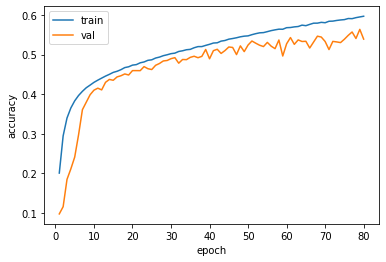

In [0]:
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(list(range(1, epochs + 1)), history['accuracy'], label='train')
plt.plot(list(range(1, epochs + 1)), history['val_accuracy'], label='val')
plt.legend()
plt.show()

Напишите ваши выводы по проделанным экспериментам: что заработало, что - не очень. Постройте график гривых обучения (здесь или выше) с кривыми обучения разных архитектур.

__Общий вывод:__  
1) Качество обучение очень сильно зависит от метода оптимизации и нужно его подбирать  
2) Обычно качество довольно быстро росло при Адаме, однако и быстрее переобучалось (при изменении batch_size), так как возникало много шума и нужно его выкидывать (именно это заработало в следующем пункте, когда нужно было добиться accuracy > 0.8)  
3) Хороших кривых обучения удалось добиться при SGD с momentum=0 (это также и дефолтный параметр в керасе), причем при увеличении batch_size сходимость при росте эпох лучше (особенно мне нравится последний полученный график при batch_size=1000). 
4) При увеличении batch_size время прохода по эпохе уменьшается, но нужно больше эпох для сходимости увеличивается  

## Свёрточная нейросеть здорового человека

Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__.

Рекоммендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь потолще, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру под чистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [0]:
from keras.layers import Dropout

In [0]:
# Удачной охоты!
model = Sequential()

model.add(InputLayer((32, 32, 3,)))

model.add(Conv2D(filters=32, kernel_size=(3, 3,), border_mode='same'))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3, 3,), border_mode='same'))
model.add(Activation('relu'))

model.add(MaxPool2D())

model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(3, 3,), border_mode='same'))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3,), border_mode='same'))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

epochs=30

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train, train_labels, validation_data=[X_val, val_labels], epochs=epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=128, kernel_size=(3, 3), padding="same")`


Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 10s 262us/step - loss: 1.5270 - accuracy: 0.4494 - val_loss: 3.9214 - val_accuracy: 0.2273
Epoch 2/30
40000/40000 [==============================] - 10s 257us/step - loss: 1.1625 - accuracy: 0.5846 - val_loss: 1.0642 - val_accuracy: 0.6181
Epoch 3/30
40000/40000 [==============================] - 10s 256us/step - loss: 1.0041 - accuracy: 0.6446 - val_loss: 0.9350 - val_accuracy: 0.6692
Epoch 4/30
40000/40000 [==============================] - 10s 247us/step - loss: 0.9161 - accuracy: 0.6786 - val_loss: 0.8865 - val_accuracy: 0.6828
Epoch 5/30
40000/40000 [==============================] - 10s 249us/step - loss: 0.8579 - accuracy: 0.6973 - val_loss: 0.7907 - val_accuracy: 0.7222
Epoch 6/30
40000/40000 [==============================] - 10s 249us/step - loss: 0.8053 - accuracy: 0.7177 - val_loss: 0.7595 - val_accuracy: 0.7363
Epoch 7/30
40000/40000 [==============================] 

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.8212
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. Может быть несколько проще, если писать этот отчет во время или сразу после каждого эксперимента.

Выводы про эксперименты выше были написаны выше, поэтому опишу результаты последнего задания (получить accuracy > 0.8).  
  
- Метрика увеличивалась при добавлении сверток с числом фильров 32 и 64, однако приходилось делать дропаут, чтобы качество увеличилось на пару процентов  
- Перед Flatten также хотелось добавить ещё одну свёртку, но качество уменьшалось  
- Также не помогал BatchNormalization :(  
- После добавления полносвязного слоя также был использован Dropout причем с наибольшим из всех до этого параметром - 0.5
- Из всех функций активаций лучше всего получалось качество при relu
- В качестве оптимизатора был выбран всё таки Адам с дефолтным батчем при обучении. Видимо, сказалось то, что не удалось выше подобрать нужное значение батча. Также при обучении с Адамом требовалось меньше эпох по сравнению с SGD